In [2]:
import pandas as pd
import time
from datetime import datetime
import lightgbm as lgb
import numpy as np
import re
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression

# Introduction

The purpose of this project is to help Rusty Bargain used car sales servic develop an app to attract new customers. 

The aims is to enable customers to quickly find out the market value of their car. Using historical data on technical specifications, trim versions, and prices, we will train multiple models to predict price. 

Specifically, we will explore LGBMRegressor, RandomForestRegressor, LinearRegression, and XGBoost. Hyperparamter tuning will be done using RandomGridSearchCV. 

For each model, we will also assess the quality of the prediction (using RMSE), prediction speed, and training speed. 

## Data preparation

Summary of Data Preparation
* Feature names converted to snake_case
* Date
     * Taking into account that VIN registration was not standardized in the US until 1954 and our latest crawled account was in 2016, we re-coded cars with registration years out of this range as `NaN`
     * Account age was calcuated by taking the timedelta from account creation to last known activity
     * Estimated car age was calculated by subtracting year of account creation from year of car registration
* Zip codes were converted to dtype object/str and then aggregated using US Postal Code Zip-1 format
     * Aggregates 8143 zip codes to 10 national regions
* Models and Brands
  * For LightGBM data-preprocepting, we take advantage of the regressors ability to handle catagorical data and cast type `objec` to `category`.
  * For other regressors, we originally attempted to encode car models and brands using one-hot-encoding, however ran into time/resource limitations while training. 
  * As an alternative, we tranform `brands` and `models` to scalars by calculating their proportion of the total car inventory history (value count / N).
  * Assuming car `model` implies car make (`brand`), separate dataframes were created with and without car `brand`
     * We will test whether inclusion is impactful on our models
* For linear regression analysis (and additional RandomForest, and XGBoost modeling) catagorical features were one-hot-encoded and stored in `linear_cars_df` (and `linear_cars_make_drop_df`)

In [46]:
cars_df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/car_data.csv')

#### Initial Data View

In [47]:
display(cars_df.head(6))
print(cars_df.info())
print()
print(cars_df['Price'].describe())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

#### Change to snake_case

In [5]:
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

cars_df.columns = [camel_to_snake(col) for col in cars_df.columns]
print(cars_df.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')


#### Missing Model Name

In [6]:
cars_df.loc[cars_df['model'].isna(), 'model'] = 'missing'

#### Processing of Datetime Features

In [7]:
date_features = ['date_crawled','date_created','last_seen']

for col in date_features:
    cars_df[col] = pd.to_datetime(cars_df[col], format="%d/%m/%Y %H:%M")

print("Latest Account Date: ", cars_df['date_crawled'].describe())
print()
print(cars_df['registration_year'].describe())

Latest Account Date:  count                  354369
unique                  15470
top       2016-03-05 14:25:00
freq                       66
first     2016-03-05 14:06:00
last      2016-04-07 14:36:00
Name: date_crawled, dtype: object

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64


In [8]:
mask = (cars_df['registration_year'] > 2016) | (cars_df['registration_year'] < 1954)
cars_df.loc[mask, 'registration_year'] = np.nan

In [9]:
cars_df['account_age'] = abs(cars_df['date_crawled'] - cars_df['date_created']) / pd.Timedelta(hours=1)
#cars_df['est_car_age'] = cars_df['date_created'].dt.year.astype(int) - cars_df['registration_year']

#cars_df = cars_df.drop(['date_crawled','date_created','last_seen'],axis = 1)

#### Zipcode - Zip5 to Regional Zip Header

In [10]:
cars_df['postal_code'] = cars_df['postal_code'].astype(str)
cars_df['zip_1'] = cars_df['postal_code'].str[:-4]
display('Number of Zip5 Postal Codes:', cars_df['postal_code'].nunique())
display('Number of Zip1 Postal Codes:', cars_df['zip_1'].nunique())

'Number of Zip5 Postal Codes:'

8143

'Number of Zip1 Postal Codes:'

10

In [11]:
cars_df = cars_df.drop('postal_code', axis=1)

In [12]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   339540 non-null  float64       
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   mileage             354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

#### Creation of Brandless DataFrame and Scalar DataFrames

In [13]:
cars_make_drop_df = cars_df.copy().drop('brand', axis = 1)

In [14]:
linear_cars_df = cars_df.copy()

model_counts = linear_cars_df['model'].value_counts()
linear_cars_df['model_proportion'] = linear_cars_df['model'].map(model_counts) / len(linear_cars_df)
linear_cars_df = linear_cars_df.drop('model', axis = 1)

In [15]:
brand_counts = linear_cars_df['brand'].value_counts()
linear_cars_df['brand_proportion'] = linear_cars_df['brand'].map(brand_counts) / len(linear_cars_df)
linear_cars_df = linear_cars_df.drop('brand', axis = 1)

In [16]:
linear_cars_df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,mileage,registration_month,fuel_type,not_repaired,date_created,number_of_pictures,last_seen,account_age,zip_1,model_proportion,brand_proportion
0,2016-03-24 11:52:00,480,NaN,1993.0,manual,0,150000,0,petrol,NaN,2016-03-24,0,2016-04-07 03:16:00,11.866667,7,0.082490,0.217324
1,2016-03-24 10:58:00,18300,coupe,2011.0,manual,190,125000,5,gasoline,yes,2016-03-24,0,2016-04-07 01:46:00,10.966667,6,0.055606,0.083122
2,2016-03-14 12:52:00,9800,suv,2004.0,auto,163,125000,8,gasoline,NaN,2016-03-14,0,2016-04-05 12:47:00,12.866667,9,0.001583,0.001910
3,2016-03-17 16:54:00,1500,small,2001.0,manual,75,150000,6,petrol,no,2016-03-17,0,2016-03-17 17:40:00,16.900000,9,0.082490,0.217324
4,2016-03-31 17:25:00,3600,small,2008.0,manual,69,90000,7,gasoline,no,2016-03-31,0,2016-04-06 10:17:00,17.416667,6,0.005870,0.015521


In [17]:
cat_features = linear_cars_df.select_dtypes(include='object').columns.tolist()

linear_cars_df = pd.get_dummies(linear_cars_df, columns=cat_features, dummy_na=True, drop_first=False)

#### Impute Missing Registration Year

In [18]:
features = ['registration_year','power','mileage','brand_proportion', 'gearbox_auto', 'not_repaired_yes']
sampled_df = linear_cars_df[features].sample(25000, random_state=42)

nan_rows = linear_cars_df[(linear_cars_df['registration_year'].isna())]

non_nan_rows = linear_cars_df[linear_cars_df['registration_year'].notna()]
sampled_non_nan = non_nan_rows.sample(n=min(25000, len(non_nan_rows)), random_state=42)

impute_df = pd.concat([nan_rows, sampled_non_nan], axis=0)

scaler = StandardScaler()
scaled = scaler.fit_transform(impute_df[features])

imputer = KNNImputer(n_neighbors=5)
scaled_imputed = imputer.fit_transform(scaled)

imputed = scaler.inverse_transform(scaled_imputed)

linear_cars_df.loc[nan_rows.index, 'registration_year'] = imputed[:len(nan_rows), features.index('registration_year')]

In [19]:
linear_cars_df['est_car_age'] = linear_cars_df['date_created'].dt.year.astype(int) - linear_cars_df['registration_year']

In [20]:
linear_cars_df = linear_cars_df.drop(['date_crawled','date_created','last_seen'],axis = 1)

#### Final Cleaning of DataFrames
Dropped extra columns and features created during feature engineering

In [21]:
cat_features2 = cars_make_drop_df.select_dtypes(include='object').columns.tolist()
linear_cars_make_drop_df = linear_cars_df.drop('brand_proportion', axis=1)

#linear_cars_make_drop_df = linear_cars_make_drop_df.drop(['date_crawled','date_created','last_seen'],axis = 1)

In [22]:
cars_df = cars_df.drop(['date_crawled','date_created','last_seen'],axis = 1)

In [23]:
cars_make_drop_df = cars_make_drop_df.drop(['date_crawled','date_created','last_seen'],axis = 1)

### Train Test Split

For brevity, dataframes are encoded accordingly
* X1, y1: `cars_df`, original dataframe
* X2, y2: `cars_make_drop_df`, brand of car dropped
* X3, y3: `linear_cars_df`, original dataframe with catagorical data one-hot-encoded
* X4, y4: `linear_cars_make_drop_df`, X2 and y2 with OHE

In [24]:
datasets = {
    'original': cars_df,
    'no_brand': cars_make_drop_df,
    'linear': linear_cars_df,
    'linear_no_brand': linear_cars_make_drop_df
}

splits = {}
for name, df in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop('price', axis=1), df['price'],
        test_size=0.2, random_state=42
    )
    splits[name] = {
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test
    }

## Model training

In [25]:
rmse_scorer = make_scorer(
    mean_squared_error,
    greater_is_better=False,
    squared=False
)

### LightGBM

In [26]:
X1_train, X1_test, y1_train, y1_test = splits['original'].values()

lgb_cat_cols = X1_train.select_dtypes(include='object').columns.tolist()

for col in lgb_cat_cols:
    X1_train[col] = X1_train[col].astype('category')
    X1_test[col] = X1_test[col].astype('category')

In [27]:
def lgb_tuning(X_train, y_train, X_test, y_test, n_iter=25):
    """
    Hyperparameter tuning for LightGBM
    """

    lgb_model = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        random_state=42,
        verbose=-1
    )

    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200],
        'num_leaves': [16, 32, 64],
        'max_depth': [3, 5, 7],
        'reg_lambda': [0, 0.1, 0.5]
    }

    random_search = RandomizedSearchCV(
        lgb_model,
        param_grid,
        n_iter=n_iter,
        cv=3,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return {
        'best_model': best_model,
        'best_params': random_search.best_params_,
        'rmse': rmse
    }

#### With Regard to Car Make (`Brand`)

In [28]:
%time original_lgb_dict = lgb_tuning(X1_train, y1_train, X1_test, y1_test)

### last runtime 1 min 42 sec

CPU times: user 11.1 s, sys: 264 ms, total: 11.4 s
Wall time: 1min 42s


In [29]:
print(original_lgb_dict)

{'best_model': LGBMRegressor(max_depth=7, metric='rmse', n_estimators=200, num_leaves=32,
              objective='regression', random_state=42, reg_lambda=0.5,
              verbose=-1), 'best_params': {'reg_lambda': 0.5, 'num_leaves': 32, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}, 'rmse': 1759.2599574515411}


#### Without Regard to Car Make (`Brand`)

In [30]:
X2_train, X2_test, y2_train, y2_test = splits['no_brand'].values()

lgb_cat_cols = X2_train.select_dtypes(include='object').columns.tolist()

for col in lgb_cat_cols:
    X2_train[col] = X2_train[col].astype('category')
    X2_test[col] = X2_test[col].astype('category')

%time no_brand_lgb_dict = lgb_tuning(X2_train, y2_train, X2_test, y2_test)

### last runtime 1 min 37 sec

CPU times: user 10.4 s, sys: 214 ms, total: 10.6 s
Wall time: 1min 37s


In [31]:
print (no_brand_lgb_dict)

{'best_model': LGBMRegressor(max_depth=7, metric='rmse', n_estimators=200, num_leaves=32,
              objective='regression', random_state=42, reg_lambda=0.5,
              verbose=-1), 'best_params': {'reg_lambda': 0.5, 'num_leaves': 32, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}, 'rmse': 1774.2271678496109}


**Note:** Elimintation of car `brand` was detrimental to RMSE without significant improvements in training time. Subsequent model testing was performed with inclusion of `brand`. 

### RandomForestRegressor



In [33]:
# last run time 496.6611785888672 sec (~8 minutes)

X3_train, X3_test, y3_train, y3_test = splits['linear'].values()

param_distributions = {
    "n_estimators": [50, 100],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 4, 6, 10],
}

rf_regressor = RandomForestRegressor(random_state=42)

rf_random_search = RandomizedSearchCV(
    rf_regressor,
    param_distributions,
    n_iter=10,
    cv=2,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

rf_start_time = time.time()

rf_random_search.fit(X3_train, y3_train)

best_rf_model = rf_random_search.best_estimator_
y3_pred = best_rf_model.predict(X3_test)

rmse_test = np.sqrt(mean_squared_error(y3_test, y3_pred))
rmse_cv   = (-rf_random_search.best_score_)**0.5

elapsed_time = time.time() - rf_start_time

print(f"Best Params for Random Forest: {rf_random_search.best_params_}")
print(f"Best Grid Search RSME: {rmse_cv}")
print(f"Test RSME: {rmse_test}")
print(f"Elapsed Time: {elapsed_time}")

Best Params for Random Forest: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None}
Best Grid Search RSME: 1800.6014092839348
Test RSME: 1746.9156957799746
Elapsed Time: 496.6611785888672


In [35]:
print(best_rf_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


### Linear Regression Modeling

In [34]:
X3_train, X3_test, y3_train, y3_test = splits['linear'].values()

lin_model = LinearRegression(n_jobs=-1)

%time lin_model.fit(X3_train, y3_train)
%time y3_preds = lin_model.predict(X3_test)

lin_rsme = mean_squared_error(y3_test, y3_preds)**.5
print ('Linear Regression RSME:', lin_rsme)

CPU times: user 630 ms, sys: 417 ms, total: 1.05 s
Wall time: 525 ms
CPU times: user 36.1 ms, sys: 37.5 ms, total: 73.6 ms
Wall time: 66.6 ms
Linear Regression RSME: 3277.865751043551


### Additional Models

#### XGBoost

Inital attempts of hyperparamter tuning using the same parameter distribution grid as LGBoostRegressor resulted in tuning time >10 minutes and was terminated. 

An alternate parameter distribution grid is enabled below. 

In [41]:
import xgboost as xgb

param_distributions = {
    'n_estimators': [25, 50],
    'max_depth': [3, 5],
    'learning_rate': [0.25, 0.5],
    'colsample_bytree': [0.66]}

xg_random_search = RandomizedSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions,
    n_iter=5,
    cv=2,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

xg_start_time = time.time()

xg_random_search.fit(X3_train, y3_train)

# Get best model and evaluate
best_xg_model = xg_random_search.best_estimator_
xg_y3_pred = best_xg_model.predict(X3_test)

elapsed_time = time.time() - xg_start_time

xg_rmse_test = np.sqrt(mean_squared_error(y3_test, xg_y3_pred))
xg_rmse_cv   = (-xg_random_search.best_score_)**0.5

print(f"Best Params for XG Boost: {xg_random_search.best_params_}")
print(f"Best Grid Search RSME: {xg_rmse_test}")
print(f"Test RSME: {xg_rmse_test}")
print(f"Elapsed Time: {elapsed_time}")

Best Params for XG Boost: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.5, 'colsample_bytree': 0.66}
Best Grid Search RSME: 1865.1617203176668
Test RSME: 1865.1617203176668
Elapsed Time: 252.88221955299377


In [43]:
print(best_xg_model.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.66, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 50, 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


## Model analysis
Standard Deviation of Historic Prices: $4514.16

### LightGB Regressor:
LGBM is an effective estimator for final car price. Retaining car make (`brand`) as a proportion of all cars resulted in a higher RMSE with minimal increase in hyperparameter tuning (RandomeCV search) and training time. Final testing resulted in a RSME of 1759.30 and a total run time of 1 min 1 sec.

Anticipated user wait time on one single car value prediction is 13.3 mili-seconds. 

One drawback with this model (and other gradient boost models) is limited interpretability of the final model. Namely, key drivers of price cannot be easily identified from the multiple training steps. 

```
{'best_model': LGBMRegressor(max_depth=7, metric='rmse', n_estimators=200, num_leaves=32,
              objective='regression', random_state=42, reg_lambda=0.5,
              verbose=-1), 'best_params': {'reg_lambda': 0.5, 'num_leaves': 32, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}, 'rmse': 1759.2599574515411}
```
Relative RSME (RSME/STD): 0.390

In [44]:
%time single_pred = original_lgb_dict['best_model'].predict(X1_test.head(1))
single_pred

CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 12.3 ms


array([16840.26208065])

### Random Forest
Random Forest resulted in a slightly better RSME 1746.92. However this method was significantly more resource intesive at 8 minutes 9 seconds during hypertuning, even when limting n-inters to 10. 

Anticipated wait time on a single use prediction is 5.26 ms. 

An advantage of the RandomForest is its ability to clearly show its decision making process. Key attributes price determination may be identified. Final hyper parameters and the first 3 levels of the best decision tree are printed below. 

```
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
```

Relative RSME: 0.387

In [45]:
%time rf_single_pred = best_rf_model.predict(X3_test.head(1))
rf_single_pred

CPU times: user 5.3 ms, sys: 3.12 ms, total: 8.42 ms
Wall time: 6.3 ms


array([17154.69692549])

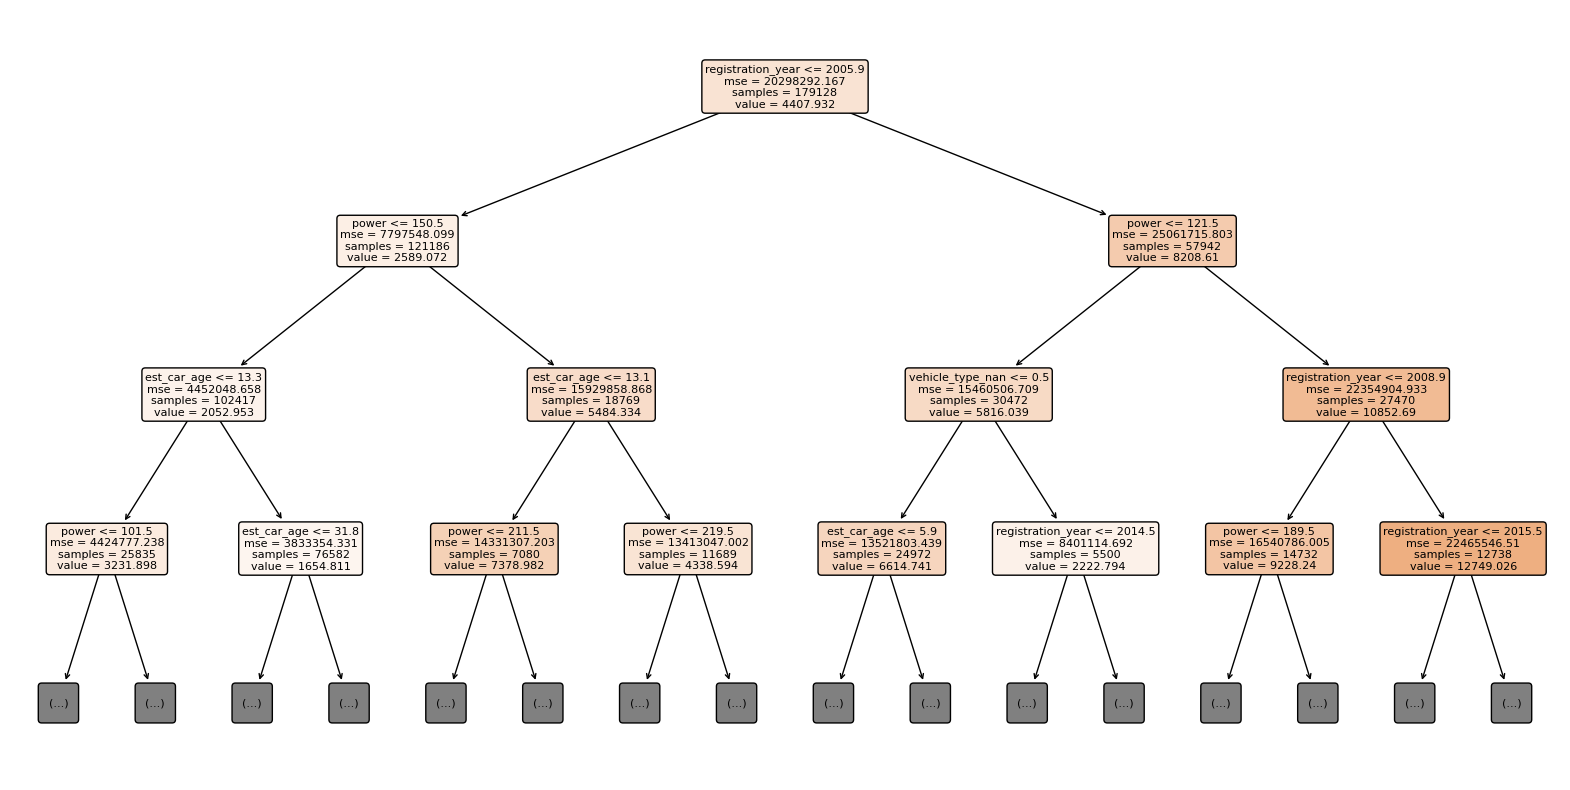

In [36]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree = best_rf_model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    feature_names=X3_train.columns,  # use the correct dataframe
    filled=True,
    rounded=True,
    fontsize=8,
    max_depth=3
)
plt.show()


### XGBoost

As expected, with larger datasets, XGBoost is not an efficient model. During hyperparameter tuning, multiple adjustments needed to be made for practical training time. 

After limiting hyperparameters tested, final tuning time was 4 minutes 13 seconds, with and RSME of 1865.16.

```
{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.66, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 50, 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
```

Relative RSME: 0.413

### Linear Regression (Sanity Check)

As sanity check, LinearRegression was run on the scalarized features. As expected, our data is poorly characterized by a single linear relationships with a RMSE of 3277.86. 

Relative RSME: 0.726

# Conclusion

For the purpose of the app, LightGBM regressor offers a good return for resoruce. The model will offer Rusty Bargain quick moment-to-moment, live price estimations without significant wait time.

However, if Rusty Bargain is willing to accept periodical updates to pricing models (i.e. quarterly), using RandomForestRegressor will provide robust price prediction with the added benefit of model transparency. This would allow markets to identify key-determinators of price. 